In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from causallearn.search.ScoreBased.GES import ges
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from itertools import permutations
import pyEDM
import os
from causallearn.search.FCMBased.lingam import VARLiNGAM

GES Method


--- Processing dataset: sim-ex1.dat ---
  Running GES...
  GES completed.


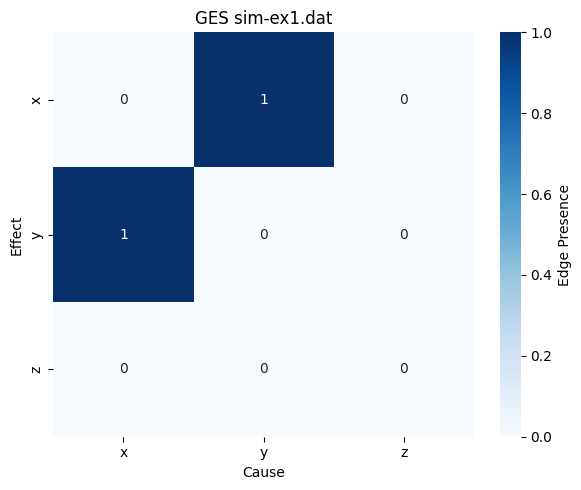


--- Causal Edges in sim-ex1.dat ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None

--- Done ---

--- Processing dataset: sim-ex2.dat ---
  Running GES...
  GES completed.


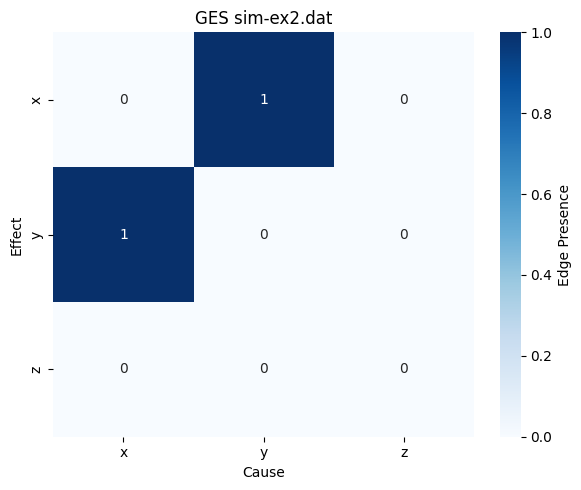


--- Causal Edges in sim-ex2.dat ---

=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None

--- Done ---


In [ ]:
# Run GES once and extract directed and undirected edges
def compute_causal_graph_single_run(data_matrix, variable_names):
    """
    Run the GES (Greedy Equivalence Search) algorithm on a single dataset and extract directed
    and undirected edges from the resulting causal graph.

    Args:
        data_matrix (np.ndarray): 2D array of shape (num_samples, num_vars) containing the data.
        variable_names (list of str): Names of the variables corresponding to the columns of data_matrix.

    Returns:
        tuple:
            edges_directed (list of tuple): List of directed edges (source, target).
            edges_undirected (list of tuple): List of undirected edges (node1, node2), bidirectional.
    """
    cg_result = ges(data_matrix)
    cg = cg_result["G"]

    edges_directed = []
    edges_undirected = []

    for edge in cg.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1

        if 0 <= n1_idx < len(variable_names) and 0 <= n2_idx < len(variable_names):
            n1 = variable_names[n1_idx]
            n2 = variable_names[n2_idx]

            ep1, ep2 = edge.get_endpoint1(), edge.get_endpoint2()
            if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
                edges_directed.append((n1, n2))
            elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
                edges_directed.append((n2, n1))
            else:
                edges_undirected += [(n1, n2), (n2, n1)]
        else:
            print(f"Warning: Invalid index in edge: {n1_idx}, {n2_idx}")

    return edges_directed, edges_undirected


# Convert edge lists into an adjacency matrix
def create_adjacency_matrix(directed_edges, undirected_edges, node_names):
    """
    Convert directed and undirected edge lists into an adjacency matrix.

    Args:
        directed_edges (list of tuple): List of directed edges (source, target).
        undirected_edges (list of tuple): List of undirected edges (node1, node2).
        node_names (list of str): Names of all nodes to define the matrix order.

    Returns:
        np.ndarray: Square adjacency matrix of shape (num_nodes, num_nodes) with 1 indicating
                    the presence of an edge and 0 otherwise. For undirected edges, both
                    [i, j] and [j, i] are set to 1.
    """
    n = len(node_names)
    matrix = np.zeros((n, n))

    for src, tgt in directed_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = 1

    for src, tgt in undirected_edges:
        if src in node_names and tgt in node_names:
            i, j = node_names.index(src), node_names.index(tgt)
            matrix[i, j] = matrix[j, i] = 1

    return matrix


# Plot heatmap for adjacency matrix
def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """
    Plot a heatmap of an adjacency matrix.

    Args:
        matrix (np.ndarray): Square adjacency matrix.
        algo_name (str): Name of the causal discovery algorithm (e.g., "GES").
        var_names (list of str): List of variable names for the axes.
        title_suffix (str, optional): Additional text to append to the plot title.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


# Process a single file
def process_file(file_path, file_label, variable_names):
    """
    Load a dataset from a file, run GES causal discovery, generate adjacency matrix,
    plot the heatmap, and print directed, undirected, and bidirectional edges.

    Args:
        file_path (str): Path to the dataset file.
        file_label (str): Label to identify the dataset in outputs and plots.
        variable_names (list of str): List of variable names corresponding to columns in the dataset.
    """
    print(f"\n--- Processing dataset: {file_label} ---")
    data = np.loadtxt(file_path)

    print("  Running GES...")
    directed, undirected = compute_causal_graph_single_run(data, variable_names)
    print("  GES completed.")

    adj_mat = create_adjacency_matrix(directed, undirected, variable_names)
    plot_heatmap(adj_mat, "GES", variable_names, file_label)

    # Print results
    print(f"\n--- Causal Edges in {file_label} ---")

    print("\n=== Directed Edges ===")
    if directed:
        for edge in sorted(set(directed)):
            print(f"{edge[0]} → {edge[1]}")
    else:
        print("None")

    print("\n=== Undirected Edges ===")
    undirected_only = {tuple(sorted((a, b))) for (a, b) in undirected
                       if (a, b) not in directed and (b, a) not in directed}
    if undirected_only:
        for edge in sorted(undirected_only):
            print(f"{edge[0]} — {edge[1]}")
    else:
        print("None")

    print("\n=== Bidirectional Edges ===")
    bidirectional = {tuple(sorted((a, b))) for (a, b) in directed
                     if (b, a) in directed}
    if bidirectional:
        for edge in sorted(bidirectional):
            print(f"{edge[0]} ↔ {edge[1]}")
    else:
        print("None")

    print("\n--- Done ---")


# === Main Execution ===
if __name__ == "__main__":
    variable_names = ['x', 'y', 'z']
    dataset_list = [
        ("./dataset/sim-ex1.dat", "sim-ex1.dat"),
        ("./dataset/sim-ex2.dat", "sim-ex2.dat")
    ]

    for file_path, label in dataset_list:
        process_file(file_path, label, variable_names)


PC Method

/opt/anaconda3/envs/torch-gpu/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



--- Processing dataset: sim-ex1.dat ---


Depth=0, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 264.53it/s] 


=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None
--- Done ---


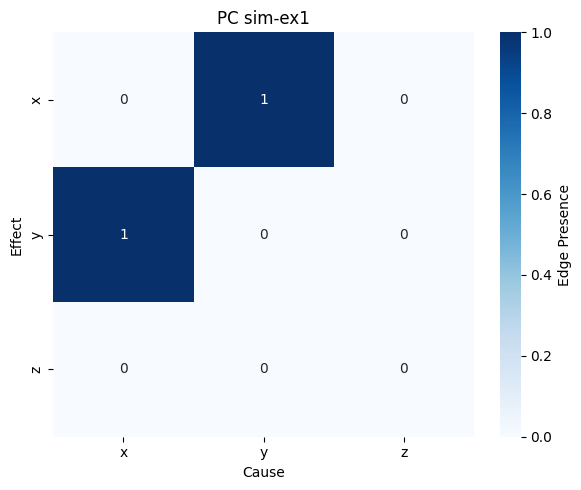


--- Processing dataset: sim-ex2.dat ---


Depth=1, working on node 2: 100%|██████████| 3/3 [00:00<00:00, 368.31it/s] 



=== Directed Edges ===
None

=== Undirected Edges ===
x — y

=== Bidirectional Edges ===
None
--- Done ---


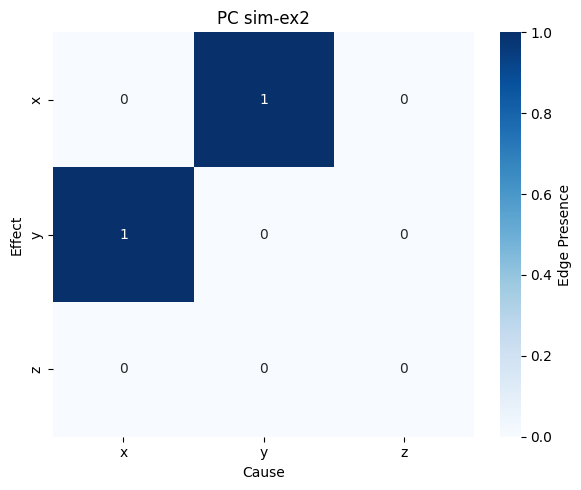

In [ ]:
# === Function definitions ===

def compute_causal_graph(data, var_names):
    """Compute the causal graph using the PC algorithm.

    Args:
        data (np.ndarray): 2D array of shape (n_samples, n_variables) containing the dataset.
        var_names (list of str): List of variable names corresponding to columns in `data`.

    Returns:
        tuple: Two lists:
            - directed (list of tuple): List of directed edges (source, target).
            - undirected (list of tuple): List of undirected edges (var1, var2) and (var2, var1).
    """
    cg = pc(data, alpha=0.05, indep_test=fisherz)
    directed = []
    undirected = []

    for edge in cg.G.get_graph_edges():
        n1_idx = int(edge.get_node1().get_name()[1:]) - 1
        n2_idx = int(edge.get_node2().get_name()[1:]) - 1
        if n1_idx >= len(var_names) or n2_idx >= len(var_names):
            continue
        n1 = var_names[n1_idx]
        n2 = var_names[n2_idx]

        ep1 = edge.get_endpoint1()
        ep2 = edge.get_endpoint2()

        if ep1 == Endpoint.ARROW and ep2 == Endpoint.TAIL:
            directed.append((n1, n2))
        elif ep1 == Endpoint.TAIL and ep2 == Endpoint.ARROW:
            directed.append((n2, n1))
        else:
            undirected.append((n1, n2))
            undirected.append((n2, n1))

    return directed, undirected


def create_frequency_matrix(directed, undirected, node_names):
    """Convert directed and undirected edges into a frequency adjacency matrix.

    Args:
        directed (list of tuple): List of directed edges (source, target).
        undirected (list of tuple): List of undirected edges (var1, var2) and (var2, var1).
        node_names (list of str): List of node names defining matrix order.

    Returns:
        np.ndarray: 2D integer array of shape (n_nodes, n_nodes) representing edge frequencies.
    """
    n = len(node_names)
    mat = np.zeros((n, n), dtype=int)

    for i, j in directed:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    for i, j in undirected:
        a = node_names.index(i)
        b = node_names.index(j)
        mat[a, b] += 1

    return mat


def plot_heatmap(matrix, algo_name, var_names, title_suffix=""):
    """Plot a heatmap for a given adjacency/frequency matrix.

    Args:
        matrix (np.ndarray): 2D array representing edges or frequencies.
        algo_name (str): Name of the causal discovery algorithm.
        var_names (list of str): List of variable names for axis labels.
        title_suffix (str, optional): Suffix to append to plot title. Defaults to "".
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt=".0f", cmap="Blues",
                xticklabels=var_names, yticklabels=var_names,
                cbar_kws={'label': 'Edge Presence'})
    plt.title(f"{algo_name} {title_suffix}")
    plt.xlabel("Cause")
    plt.ylabel("Effect")
    plt.tight_layout()
    plt.show()
    plt.close()


def run_on_dataset(file_path, var_names):
    """Run the PC algorithm on a single dataset and visualize results.

    Args:
        file_path (str): Path to the dataset file (CSV or space-separated format).
        var_names (list of str): List of variable names corresponding to dataset columns.
    """
    print(f"\n--- Processing dataset: {file_path.split('/')[-1]} ---")

    df = pd.read_csv(file_path, header=None, sep=r'\s+')
    df.columns = var_names
    data = df.values

    directed_edges, undirected_edges = compute_causal_graph(data, var_names)
    matrix = create_frequency_matrix(directed_edges, undirected_edges, var_names)

    # Print results
    print("\n=== Directed Edges ===")
    if directed_edges:
        for e in sorted(set(directed_edges)):
            print(f"{e[0]} → {e[1]}")
    else:
        print("None")

    undir_set = set(frozenset((a, b)) for (a, b) in undirected_edges if a != b)
    print("\n=== Undirected Edges ===")
    if undir_set:
        for e in sorted(undir_set, key=lambda x: sorted(x)):
            a, b = sorted(e)
            print(f"{a} — {b}")
    else:
        print("None")

    print("\n=== Bidirectional Edges ===")
    bidir = set((a, b) for (a, b) in directed_edges if (b, a) in directed_edges)
    if bidir:
        for a, b in sorted(bidir):
            print(f"{a} ↔ {b}")
    else:
        print("None")

    print("--- Done ---")

    plot_heatmap(matrix, "PC", var_names, title_suffix=file_path.split("/")[-1].replace(".dat", ""))


# === Main execution ===

file_paths = [
    "./dataset/sim-ex1.dat",
    "./dataset/sim-ex2.dat"
]

variable_names = ['x', 'y', 'z']

for path in file_paths:
    run_on_dataset(path, variable_names)


Granger Causality Test

CCM Method


--- Processing dataset: sim-ex1.dat ---

Potential causal edges (x → y) with rho > 0.2:
x → y (lag=3): rho = 0.405
y → x (lag=0): rho = 0.417


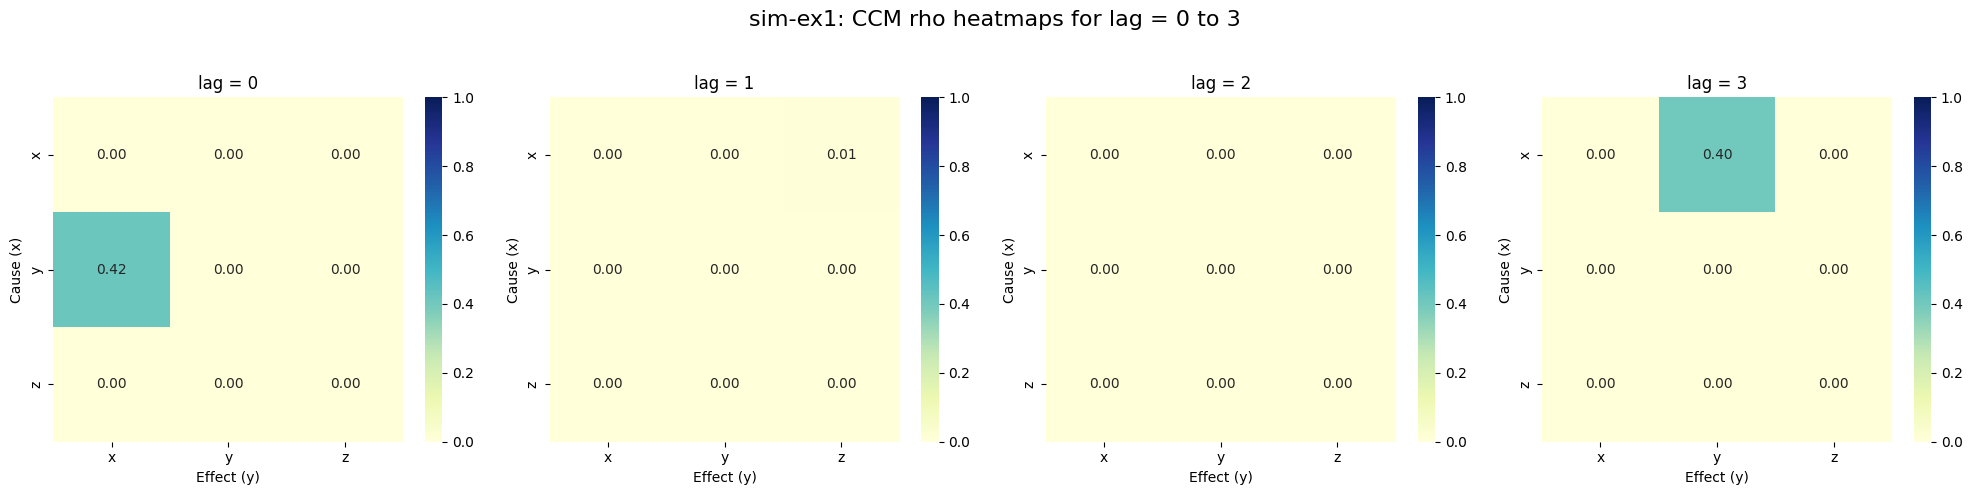

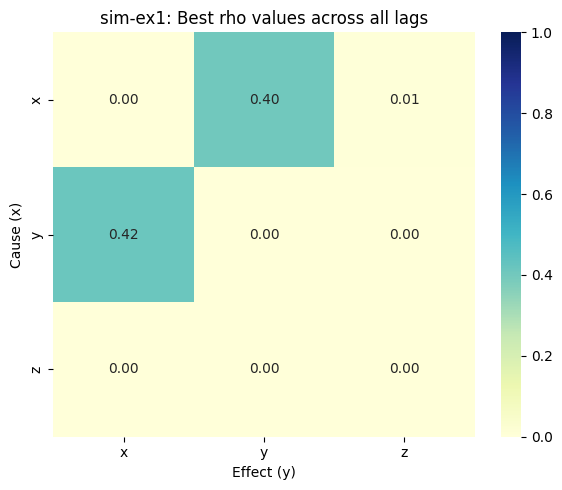


--- Processing dataset: sim-ex2.dat ---

Potential causal edges (x → y) with rho > 0.2:
x → y (lag=0): rho = 0.987
y → x (lag=0): rho = 0.952


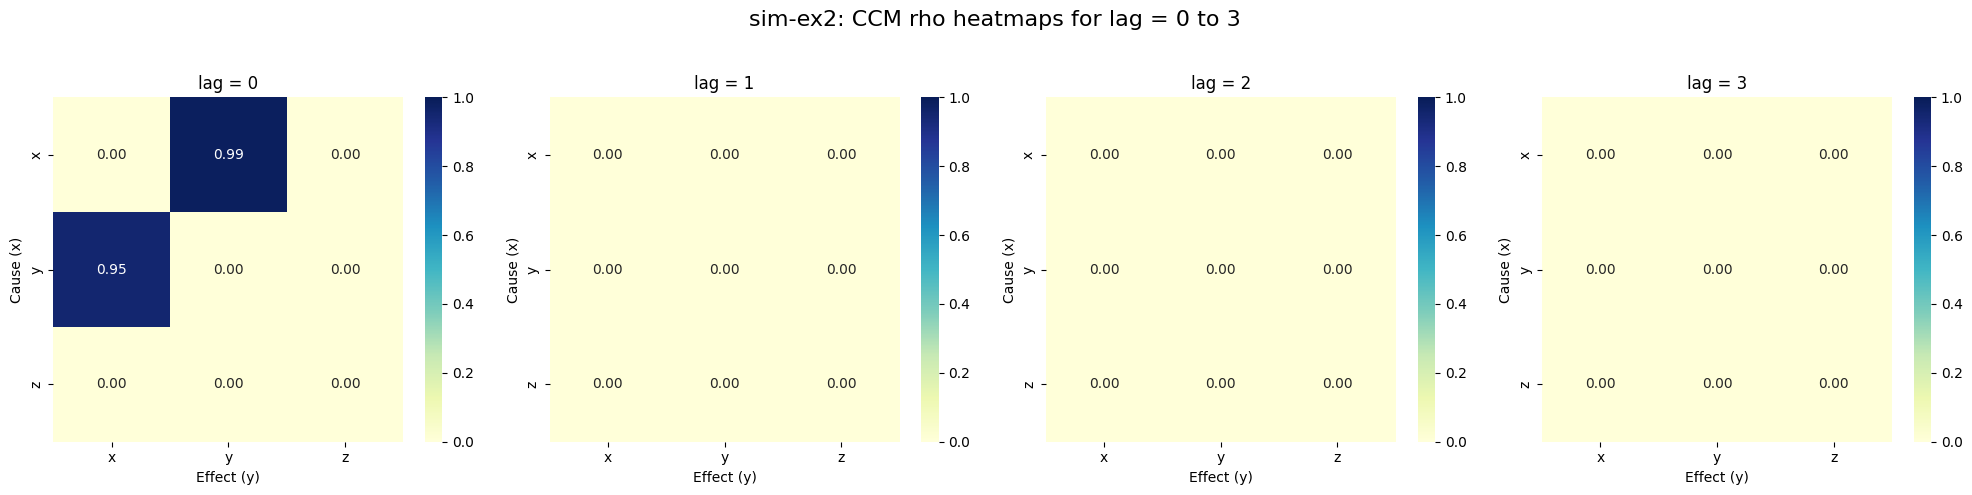

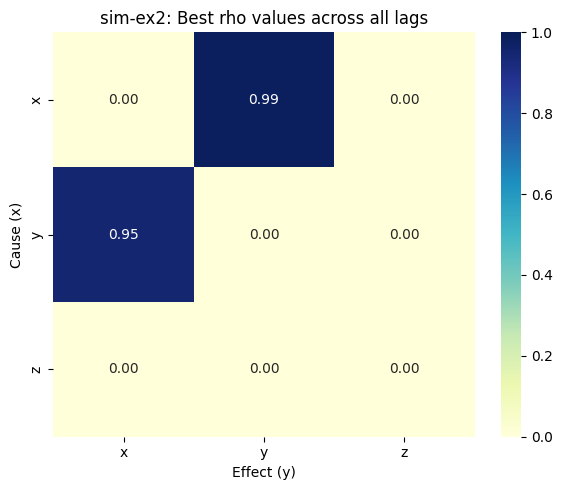


--- All dataset analyses complete! ---


In [5]:
# --- Configuration ---
file_paths = [
    "./dataset/sim-ex1.dat",
    "./dataset/sim-ex2.dat"
]

threshold = 0.2
max_lag_to_test = 3
E = 2
libSizes = "20 80 20"
sample = 100


# --- Function Definitions ---
def compute_ccm_with_lag(x, y, E=2, libSizes="20 80 20", sample=100, max_lag=3):
    """Compute CCM (Convergent Cross Mapping) correlations for a range of lags.

    Args:
        x (array-like): Time series considered as the potential cause.
        y (array-like): Time series considered as the potential effect.
        E (int, optional): Embedding dimension. Defaults to 2.
        libSizes (str, optional): Library sizes for CCM. Defaults to "20 80 20".
        sample (int, optional): Number of samples for CCM. Defaults to 100.
        max_lag (int, optional): Maximum lag to test. Defaults to 3.

    Returns:
        list of tuples: Each tuple contains (lag, rho) where rho is the CCM correlation
        for that lag.
    """
    results = []
    for lag in range(0, max_lag + 1):
        shifted_y = pd.Series(y).shift(-lag)
        df_ccm_aligned = pd.DataFrame({
            "time": np.arange(len(x)),
            "x": x,
            "y_shifted": shifted_y
        }).dropna().reset_index(drop=True)

        if df_ccm_aligned.empty:
            rho = np.nan
        else:
            try:
                result = pyEDM.CCM(
                    dataFrame=df_ccm_aligned,
                    E=E,
                    columns="x",
                    target="y_shifted",
                    libSizes=libSizes,
                    sample=sample,
                    embedded=True,
                    showPlot=False
                )
                rho = result["x:y_shifted"].values[-1]
            except Exception as e:
                print(f"Error in pyEDM.CCM for lag {lag}: {e}")
                rho = np.nan
        results.append((lag, rho))
    return results


# --- Main Loop over Datasets ---
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    print(f"\n--- Processing dataset: {file_name} ---")

    # Load dataset
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    df.columns = ['x', 'y', 'z']
    variables = df.columns.tolist()
    n_vars = len(variables)

    # Analyze all pairs of variables
    causal_results = []
    for i, j in permutations(range(n_vars), 2):
        source_var = variables[i]
        target_var = variables[j]
        x = df[source_var].values
        y = df[target_var].values
        lag_results = compute_ccm_with_lag(x, y, E=E, libSizes=libSizes, sample=sample, max_lag=max_lag_to_test)
        valid = [(lag, rho) for lag, rho in lag_results if not np.isnan(rho)]
        if valid:
            best_lag, best_rho = max(valid, key=lambda item: item[1])
        else:
            best_lag, best_rho = np.nan, np.nan
        causal_results.append((source_var, target_var, best_lag, best_rho))

    # --- Print Significant Results ---
    print(f"\nPotential causal edges (x → y) with rho > {threshold}:")
    significant_edges = [edge for edge in causal_results if not np.isnan(edge[3]) and edge[3] > threshold]
    if significant_edges:
        for source, target, lag, rho in significant_edges:
            print(f"{source} → {target} (lag={int(lag)}): rho = {rho:.3f}")
    else:
        print("No significant causal edges found above the threshold.")

    # --- Plot: Heatmaps for all lags ---
    fig, axes = plt.subplots(1, max_lag_to_test + 1, figsize=(5 * (max_lag_to_test + 1), 5))
    for idx, lag in enumerate(range(0, max_lag_to_test + 1)):
        matrix = np.zeros((n_vars, n_vars))
        for source, target, best_lag, rho in causal_results:
            if not np.isnan(rho) and best_lag == lag:
                i = variables.index(source)
                j = variables.index(target)
                matrix[i, j] = rho
        sns.heatmap(matrix, annot=True, xticklabels=variables, yticklabels=variables,
                    cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1, ax=axes[idx])
        axes[idx].set_title(f"lag = {lag}")
        axes[idx].set_xlabel("Effect (y)")
        axes[idx].set_ylabel("Cause (x)")
    fig.suptitle(f"{file_name.replace('.dat', '')}: CCM rho heatmaps for lag = 0 to {max_lag_to_test}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    plt.close()

    # --- Plot: Best rho heatmap across all lags ---
    best_rho_matrix = np.zeros((n_vars, n_vars))
    for source, target, best_lag, best_rho in causal_results:
        if not np.isnan(best_rho):
            i = variables.index(source)
            j = variables.index(target)
            best_rho_matrix[i, j] = best_rho

    plt.figure(figsize=(6, 5))
    sns.heatmap(best_rho_matrix, annot=True, xticklabels=variables, yticklabels=variables,
                cmap="YlGnBu", fmt=".2f", vmin=0, vmax=1)
    plt.title(f"{file_name.replace('.dat', '')}: Best rho values across all lags")
    plt.xlabel("Effect (y)")
    plt.ylabel("Cause (x)")
    plt.tight_layout()
    plt.show()
    plt.close()

print("\n--- All dataset analyses complete! ---")


VARLiNGAM


========== Processing: sim-ex1.dat ==========

--- Strong Causal Edges (|strength| > 0.1) ---

Lag 0:
y(t-0) → x(t): strength = 0.902

Lag 1:
x(t-1) → x(t): strength = 1.252
y(t-1) → x(t): strength = -1.271
y(t-1) → y(t): strength = 1.287
z(t-1) → z(t): strength = 1.668

Lag 2:
x(t-2) → x(t): strength = -0.101
y(t-2) → x(t): strength = 0.170
y(t-2) → y(t): strength = -0.121
z(t-2) → z(t): strength = -0.534

Lag 3:
z(t-3) → z(t): strength = -0.122

Lag 4:
No strong causal edges.

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
No strong causal edges.

Lag 8:
No strong causal edges.

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
No strong causal edges.

Lag 12:
No strong causal edges.

Lag 13:
No strong causal edges.

Lag 14:
No strong causal edges.

Lag 15:
No strong causal edges.


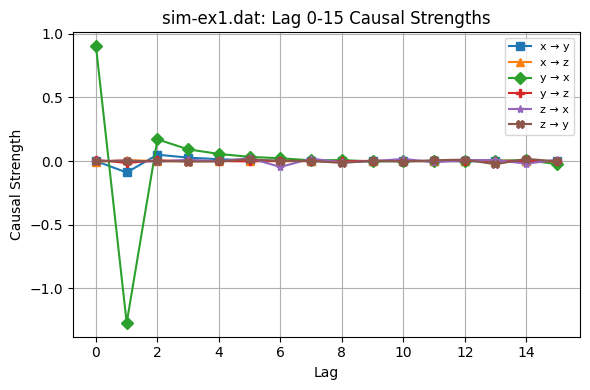

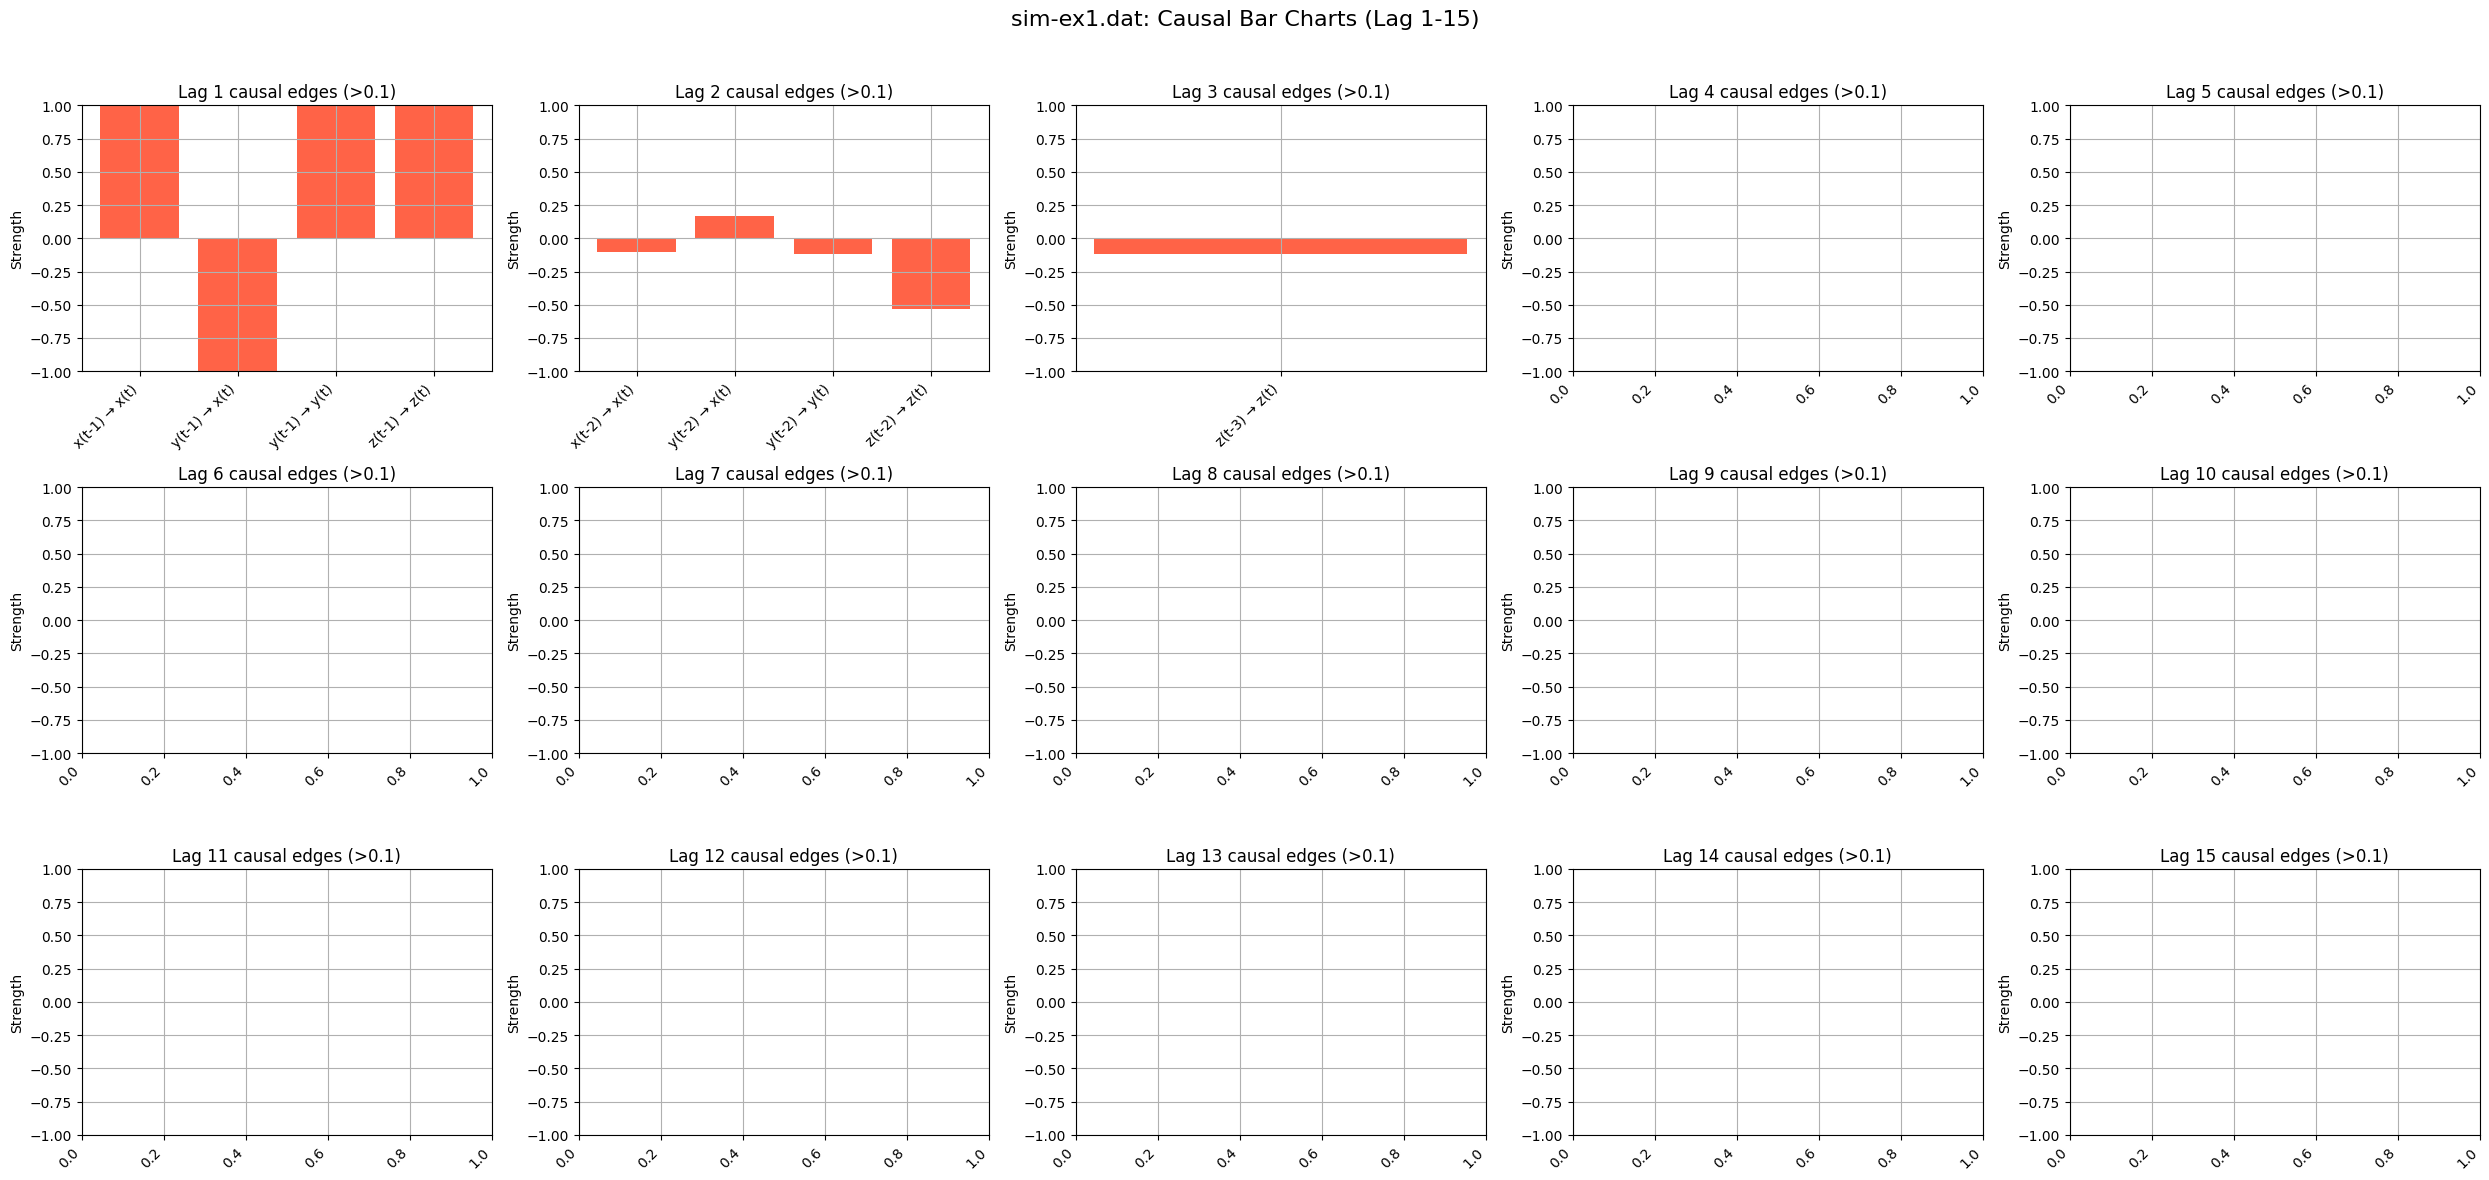


========== Processing: sim-ex2.dat ==========

--- Strong Causal Edges (|strength| > 0.1) ---

Lag 0:
No strong causal edges.

Lag 1:
x(t-1) → x(t): strength = 1.029
x(t-1) → y(t): strength = -0.148
y(t-1) → y(t): strength = 1.610
z(t-1) → z(t): strength = 1.828

Lag 2:
y(t-2) → y(t): strength = -0.475
z(t-2) → x(t): strength = -0.109
z(t-2) → z(t): strength = -0.792

Lag 3:
y(t-3) → y(t): strength = -0.201

Lag 4:
z(t-4) → x(t): strength = 0.119

Lag 5:
No strong causal edges.

Lag 6:
No strong causal edges.

Lag 7:
z(t-7) → x(t): strength = 0.134

Lag 8:
z(t-8) → x(t): strength = -0.127

Lag 9:
No strong causal edges.

Lag 10:
No strong causal edges.

Lag 11:
No strong causal edges.

Lag 12:
No strong causal edges.

Lag 13:
z(t-13) → x(t): strength = 0.145

Lag 14:
z(t-14) → x(t): strength = -0.146

Lag 15:
No strong causal edges.


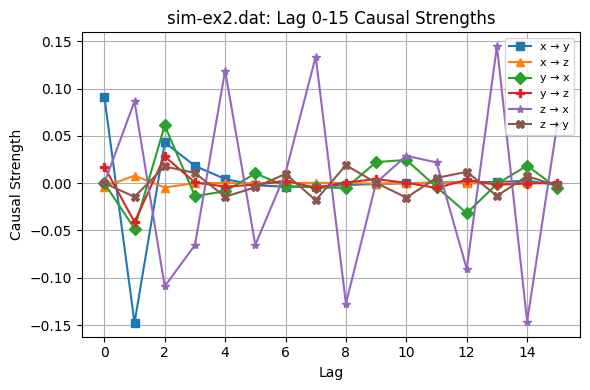

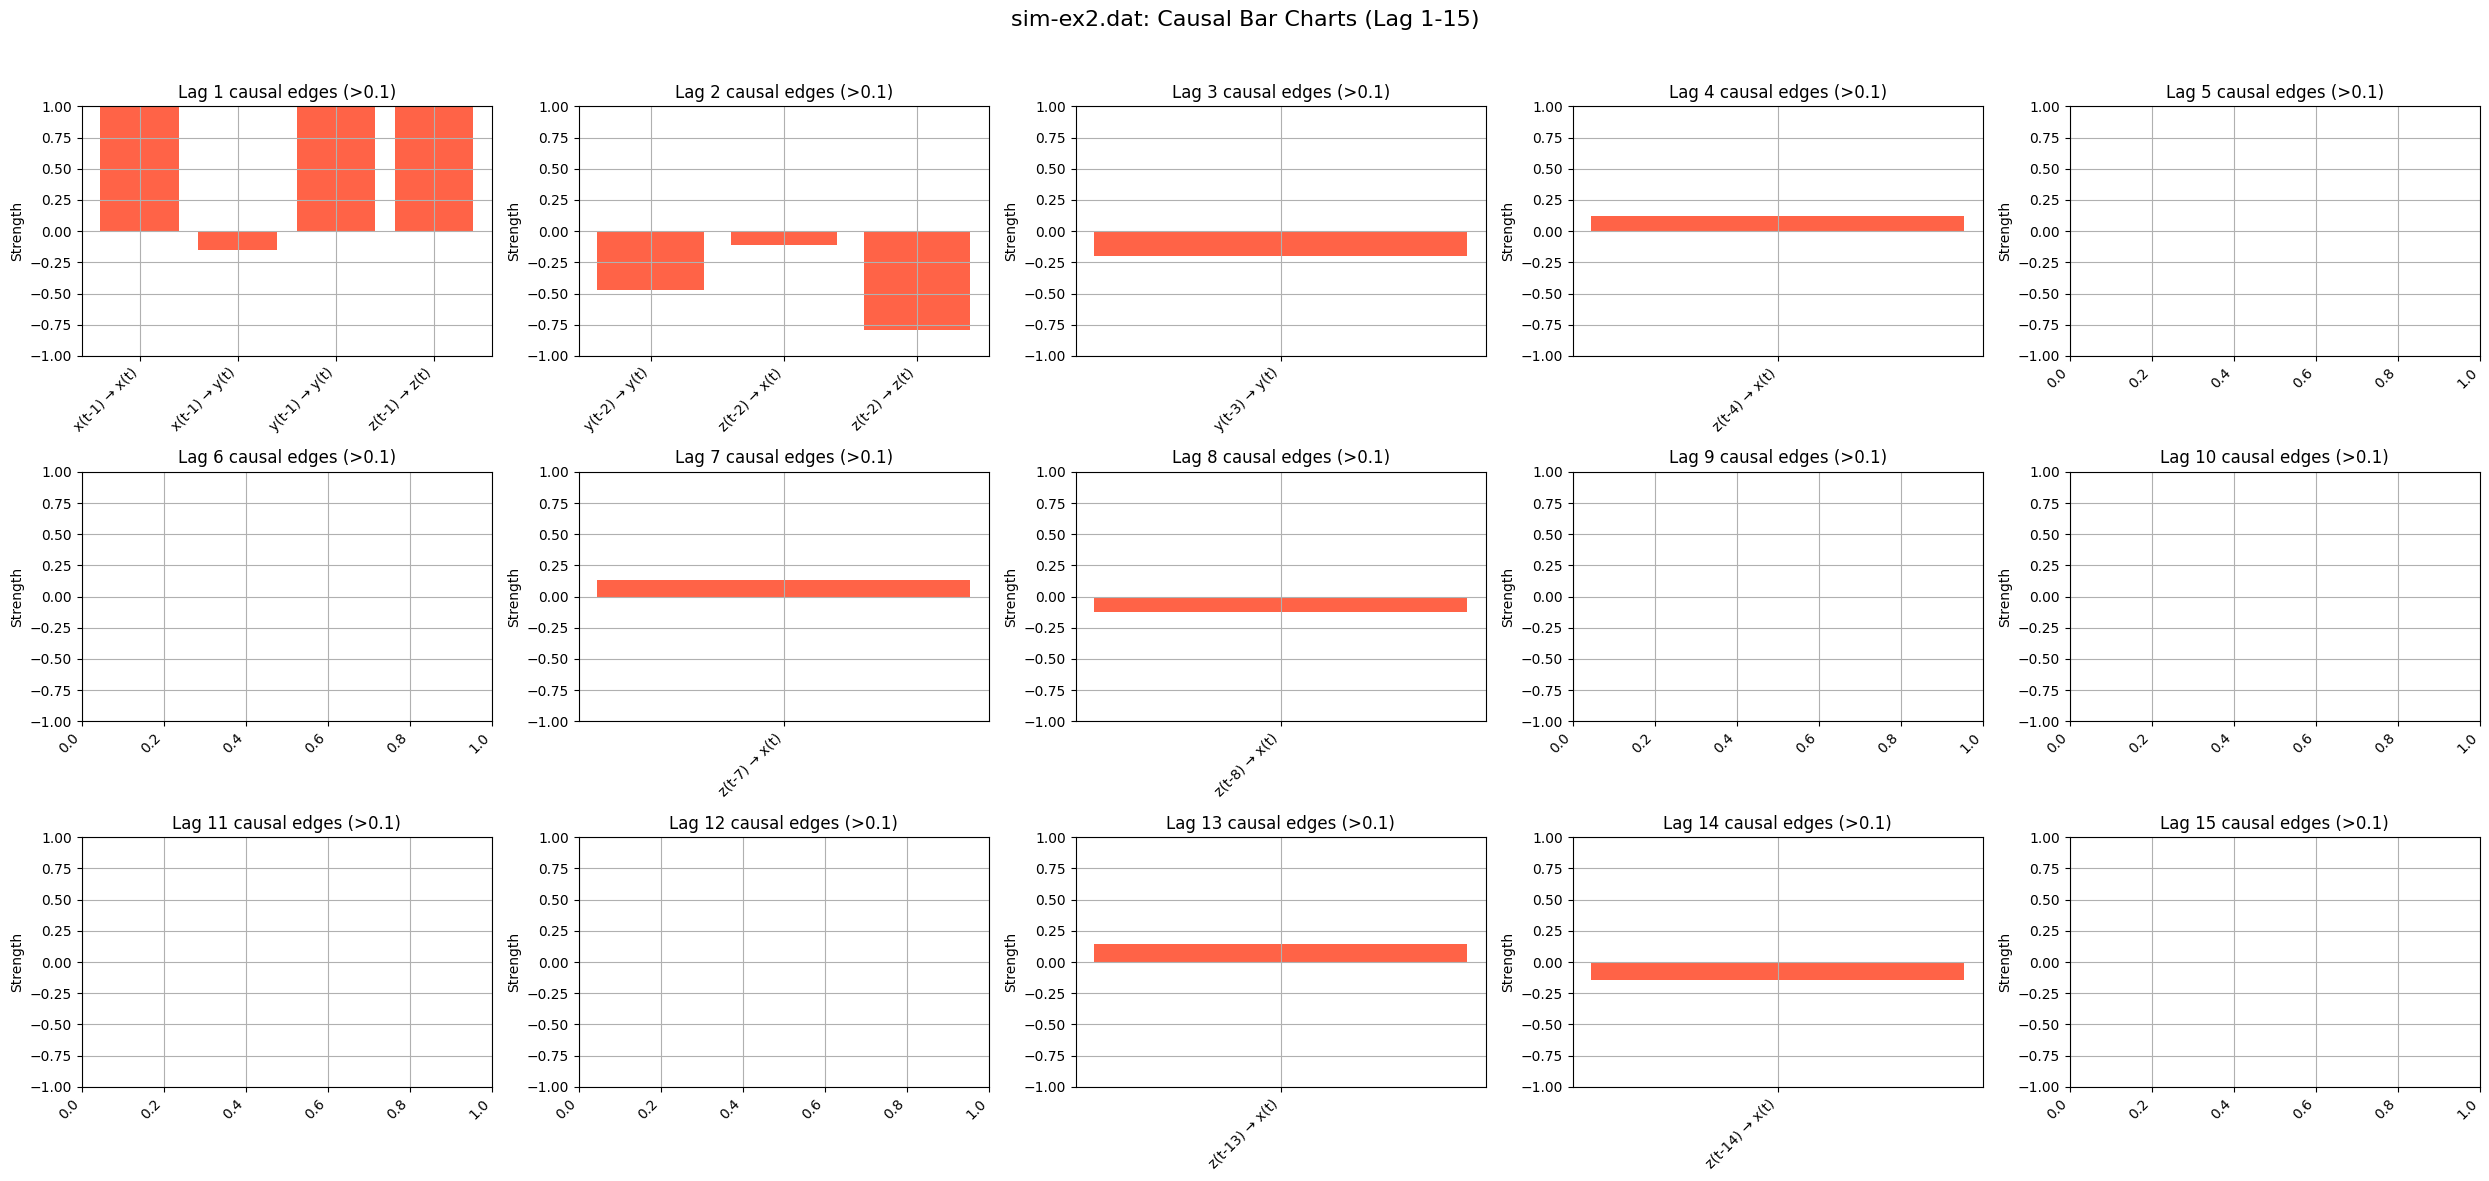

All datasets processed.


In [ ]:
# --- Global settings ---
file_paths = [
    "./dataset/sim-ex1.dat",
    "./dataset/sim-ex2.dat"
]
var_names = ['x', 'y', 'z']
threshold = 0.1
max_lag = 15
markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h']


def load_dataset(file_path, var_names):
    """Load a whitespace-delimited dataset and assign column names.

    Args:
        file_path (str): Path to the dataset file.
        var_names (list of str): List of variable names.

    Returns:
        pd.DataFrame: Loaded dataset with named columns.
    """
    df = pd.read_csv(file_path, delim_whitespace=True, header=None)
    df.columns = var_names
    return df


def fit_varlingam(data, max_lag):
    """Fit a VARLiNGAM model to multivariate time series data.

    Args:
        data (np.ndarray): 2D array of shape (n_samples, n_variables).
        max_lag (int): Maximum lag to consider in the VARLiNGAM model.

    Returns:
        VARLiNGAM: Fitted VARLiNGAM model object.
    """
    model = VARLiNGAM(lags=max_lag, criterion=None, prune=False, random_state=42)
    model.fit(data)
    return model


def extract_causal_strengths(model, num_vars):
    """Extract causal strengths for all variable pairs across lags.

    Args:
        model (VARLiNGAM): Fitted VARLiNGAM model.
        num_vars (int): Number of variables in the dataset.

    Returns:
        dict: Keys are (cause_idx, effect_idx), values are lists of strengths across lags.
    """
    strengths = {(i, j): [] for i in range(num_vars) for j in range(num_vars)}
    for lag, mat in enumerate(model.adjacency_matrices_):
        for i in range(num_vars):
            for j in range(num_vars):
                strengths[(i, j)].append(mat[j, i])  # direction: j ← i
    return strengths


def plot_causal_strength_curves(causal_strengths, var_names, max_lag, file_name):
    """Plot causal strength curves for all variable pairs across lags.

    Args:
        causal_strengths (dict): Dictionary of causal strengths.
        var_names (list of str): List of variable names.
        max_lag (int): Maximum lag to plot.
        file_name (str): Name of the dataset file for plot titles.
    """
    plt.figure(figsize=(6, 4))
    for idx, ((cause, effect), values) in enumerate(causal_strengths.items()):
        if cause == effect:
            continue
        plt.plot(range(max_lag + 1), values, label=f'{var_names[cause]} → {var_names[effect]}',
                 marker=markers[idx % len(markers)])
    plt.title(f"{file_name}: Lag 0-{max_lag} Causal Strengths")
    plt.xlabel("Lag")
    plt.ylabel("Causal Strength")
    plt.grid(True)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_causal_bar_charts(model, var_names, threshold, max_lag, file_name):
    """Plot bar charts of strong causal edges for each lag from 1 to max_lag.

    Args:
        model (VARLiNGAM): Fitted VARLiNGAM model.
        var_names (list of str): List of variable names.
        threshold (float): Minimum absolute causal strength to display.
        max_lag (int): Maximum lag to plot.
        file_name (str): Name of the dataset file for plot titles.
    """
    n_rows = 3
    n_cols = 5
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axs = axs.flatten()

    for lag in range(1, max_lag + 1):
        ax = axs[lag - 1]
        mat = model.adjacency_matrices_[lag]
        for i in range(len(var_names)):
            for j in range(len(var_names)):
                strength = mat[j, i]
                if abs(strength) > threshold:
                    label = f'{var_names[i]}(t-{lag}) → {var_names[j]}(t)'
                    ax.bar(label, strength, color='tomato')
        ax.set_title(f"Lag {lag} causal edges (>{threshold})")
        ax.set_ylabel("Strength")
        ax.set_ylim(-1, 1)
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        ax.grid(True)

    # Remove unused subplots
    for i in range(max_lag, len(axs)):
        fig.delaxes(axs[i])

    fig.suptitle(f"{file_name}: Causal Bar Charts (Lag 1-{max_lag})", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# --- Main processing loop ---
for file_path in file_paths:
    file_name = os.path.basename(file_path)
    print(f"\n========== Processing: {file_name} ==========")

    df = load_dataset(file_path, var_names)
    data = df.values
    num_vars = data.shape[1]

    model = fit_varlingam(data, max_lag)
    causal_strengths = extract_causal_strengths(model, num_vars)

    # Print strong causal edges
    print(f"\n--- Strong Causal Edges (|strength| > {threshold}) ---")
    for lag in range(max_lag + 1):
        mat = model.adjacency_matrices_[lag]
        print(f"\nLag {lag}:")
        found = False
        for i in range(num_vars):
            for j in range(num_vars):
                strength = mat[j, i]
                if abs(strength) > threshold:
                    print(f"{var_names[i]}(t-{lag}) → {var_names[j]}(t): strength = {strength:.3f}")
                    found = True
        if not found:
            print("No strong causal edges.")

    plot_causal_strength_curves(causal_strengths, var_names, max_lag, file_name)
    plot_causal_bar_charts(model, var_names, threshold, max_lag, file_name)

print("All datasets processed.")
